In [1]:
from flowjax.flows import BlockNeuralAutoregressiveFlow, NeuralSplineFlow
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, HMC, MixedHMC, init_to_value
from rnpe.denoise import spike_and_slab_denoiser
from rnpe.tasks import SIR, Gaussian, CS
import matplotlib.pyplot as plt


In [2]:
# Plot behaviour of NPE and RNPE with increasing misspecification

In [3]:
seed = 0
task = Gaussian()
key, subkey = random.split(random.PRNGKey(seed))
data = task.generate_dataset(subkey, 50000)

key, flow_key, train_key = random.split(key, 3)
base_dist = Normal(data["x"].shape[1])
x_flow = BlockNeuralAutoregressiveFlow(flow_key, base_dist)
x_flow, x_losses = train_flow(
        train_key,
        x_flow,
        data["x"],
        learning_rate=0.01,
        max_epochs=50,
    )

# Carry out posterior inference
key, flow_key, train_key = random.split(key, 3)
base_dist = Normal(data["theta"].shape[1])
posterior_flow = NeuralSplineFlow(flow_key, base_dist, cond_dim=data["x"].shape[1],)

posterior_flow, npe_losses = train_flow(
    train_key,
    posterior_flow,
    data["theta"],
    data["x"],
    max_epochs=50,
    learning_rate=0.0005,
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
 38%|███▊      | 19/50 [00:41<01:07,  2.16s/it, train=2.84, val=2.85]

Max patience reached.



 24%|██▍       | 12/50 [02:49<08:57, 14.14s/it, train=-2.39, val=-2.35]

Max patience reached.


In [4]:

# Denoise observation with MCMC
init = init_to_value(
    values={"x": data["x"][0], "misspecified": jnp.ones(len(data["y"]), int)}
)

kernel = MixedHMC(
    HMC(spike_and_slab_denoiser, trajectory_length=1, init_strategy=init, target_accept_prob=0.95)
)

mcmc = MCMC(
    kernel,
    num_warmup=20000,
    num_samples=100000,
)

dgp_variances = range(1,5)
denoised_data = []
observations = []

key, subkey = random.split(key)
for v in dgp_variances:
    obs = Gaussian(dgp_var = v).generate_observation(subkey)[1]
    obs = (obs - task.scales["x_mean"])/task.scales["x_std"]
    key, mcmc_key = random.split(key)
    model_kwargs = {"y_obs": obs, "flow": x_flow}
    mcmc.run(mcmc_key, **model_kwargs)

    observations.append(obs)
    denoised_data.append(mcmc.get_samples()["x"])


  0%|          | 0/120000 [00:00<?, ?it/s]/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/120000 [00:00<?, ?it/s]/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/120000 [00:00<?, ?it/s]/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  

In [49]:
from scipy.stats.distributions import norm
from rnpe.metrics import robust_posterior_log_prob

thin = 500
lims_adjust = [[0, 0], [-0.5, 0], [0,0], [0, 0]]

data_4_plot = []
for i in range(len(dgp_variances)):
    unscaled_obs = observations[i]*task.scales["x_std"] + task.scales["x_mean"]


    mu, std = Gaussian(dgp_var=dgp_variances[i]).get_true_posterior_mean_std(obs_mean=unscaled_obs[0])
    mu, std = mu.item(), std.item()
    # lims = [mu-6*std, mu+6*std]  # For the plot

    # Sample from NPE to adjust lims
    lims = [mu-4*std + lims_adjust[i][0], mu+4*std + lims_adjust[i][1]]

    # Densities are learned on scaled data so will convert to scaled space and back
    scaled_lims = [(l - task.scales["theta_mean"].item()) / task.scales["theta_std"].item() for l in lims]
    theta_4_plot_scaled = jnp.linspace(*scaled_lims, 200)[:, None]
    theta_4_plot_unscaled = theta_4_plot_scaled*task.scales["theta_std"] + task.scales["theta_mean"]

    scale_correction = jnp.log(task.scales["theta_std"]).item()  # Control for scaling transformation
    naive_log_probs = posterior_flow.log_prob(theta_4_plot_scaled, observations[i]) - scale_correction
    robust_log_probs = robust_posterior_log_prob(posterior_flow, theta_4_plot_scaled, denoised_data[i][::thin]) - scale_correction

    true_dgp_probs = norm.pdf(theta_4_plot_unscaled, loc=mu, scale=std).squeeze()
    label_sufffix = str(dgp_variances[i]) if dgp_variances[i] != 1 else str(dgp_variances[i]) + " (well specified)"


    # Compute true "simulator" posterior
    sim_mu, sim_std = Gaussian(dgp_var=1).get_true_posterior_mean_std(obs_mean=unscaled_obs[0])
    true_simulator_probs = norm.pdf(theta_4_plot_unscaled, loc=sim_mu, scale=sim_std).squeeze()

    data_4_plot.append(
        {
        r"$\theta$": theta_4_plot_unscaled,
        "NPE": jnp.exp(naive_log_probs),
        "RNPE": jnp.exp(robust_log_probs),
        "True (simulator)": true_simulator_probs,
        "True (DGP)": true_dgp_probs,
        "title": r"$\sigma^2=$" + label_sufffix
        }
    )


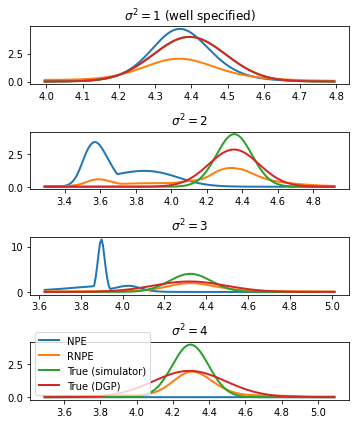

In [50]:
fig, axes = plt.subplots(nrows=len(dgp_variances))

for data, ax in zip(data_4_plot, axes):
    for posterior in ["NPE", "RNPE", "True (simulator)", "True (DGP)"]:
        ax.plot(data[r"$\theta$"], data[posterior], label=posterior, linewidth=2)    
    ax.set_title(data["title"])
ax.legend()
fig.set_size_inches(5, 6)
plt.tight_layout()
